In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import missingno as msno

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [4]:
ds = pd.read_csv("..\\data\\Life_Expectancy_Data.csv",sep=",")

In [5]:
print('columns count - ',len(ds.columns), '\n')
print('columns: ',list(ds.columns))

columns count -  22 

columns:  ['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [6]:
print('Sample count', ds.shape[0])

Sample count 2938


In [7]:
ds.rename(columns={'Life expectancy ':'Life expectancy',  'Measles ': 'Measles', 'infant deaths' :'Infant deaths',' BMI ':'BMI', 'under-five deaths ': 'Under-five deaths',  'Diphtheria ':  'Diphtheria',  ' thinness  1-19 years': 'Thinness  1-19 years', ' thinness 5-9 years':'Thinness 5-9 years'}, inplace=True)

In [8]:
ds.head()

,Country,Year,Status,Life expectancy,Adult Mortality,Infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [9]:
print("Any missing sample in training set:",ds.isnull().values.any())#чи є втрачені дані взагалі

Any missing sample in training set: True


In [10]:

def missing(ds):
    missing = []
    
    for x in ds.columns:
        if ds[x].isnull().sum() != 0:
            print(x, ds[x].isnull().sum())
            missing.append(x)
    return missing
            

In [11]:
 miss=missing(ds) # 30=1%

Life expectancy 10
Adult Mortality 10
Alcohol 194
Hepatitis B 553
BMI 34
Polio 19
Total expenditure 226
Diphtheria 19
GDP 448
Population 652
Thinness  1-19 years 34
Thinness 5-9 years 34
Income composition of resources 167
Schooling 163


<Axes: >

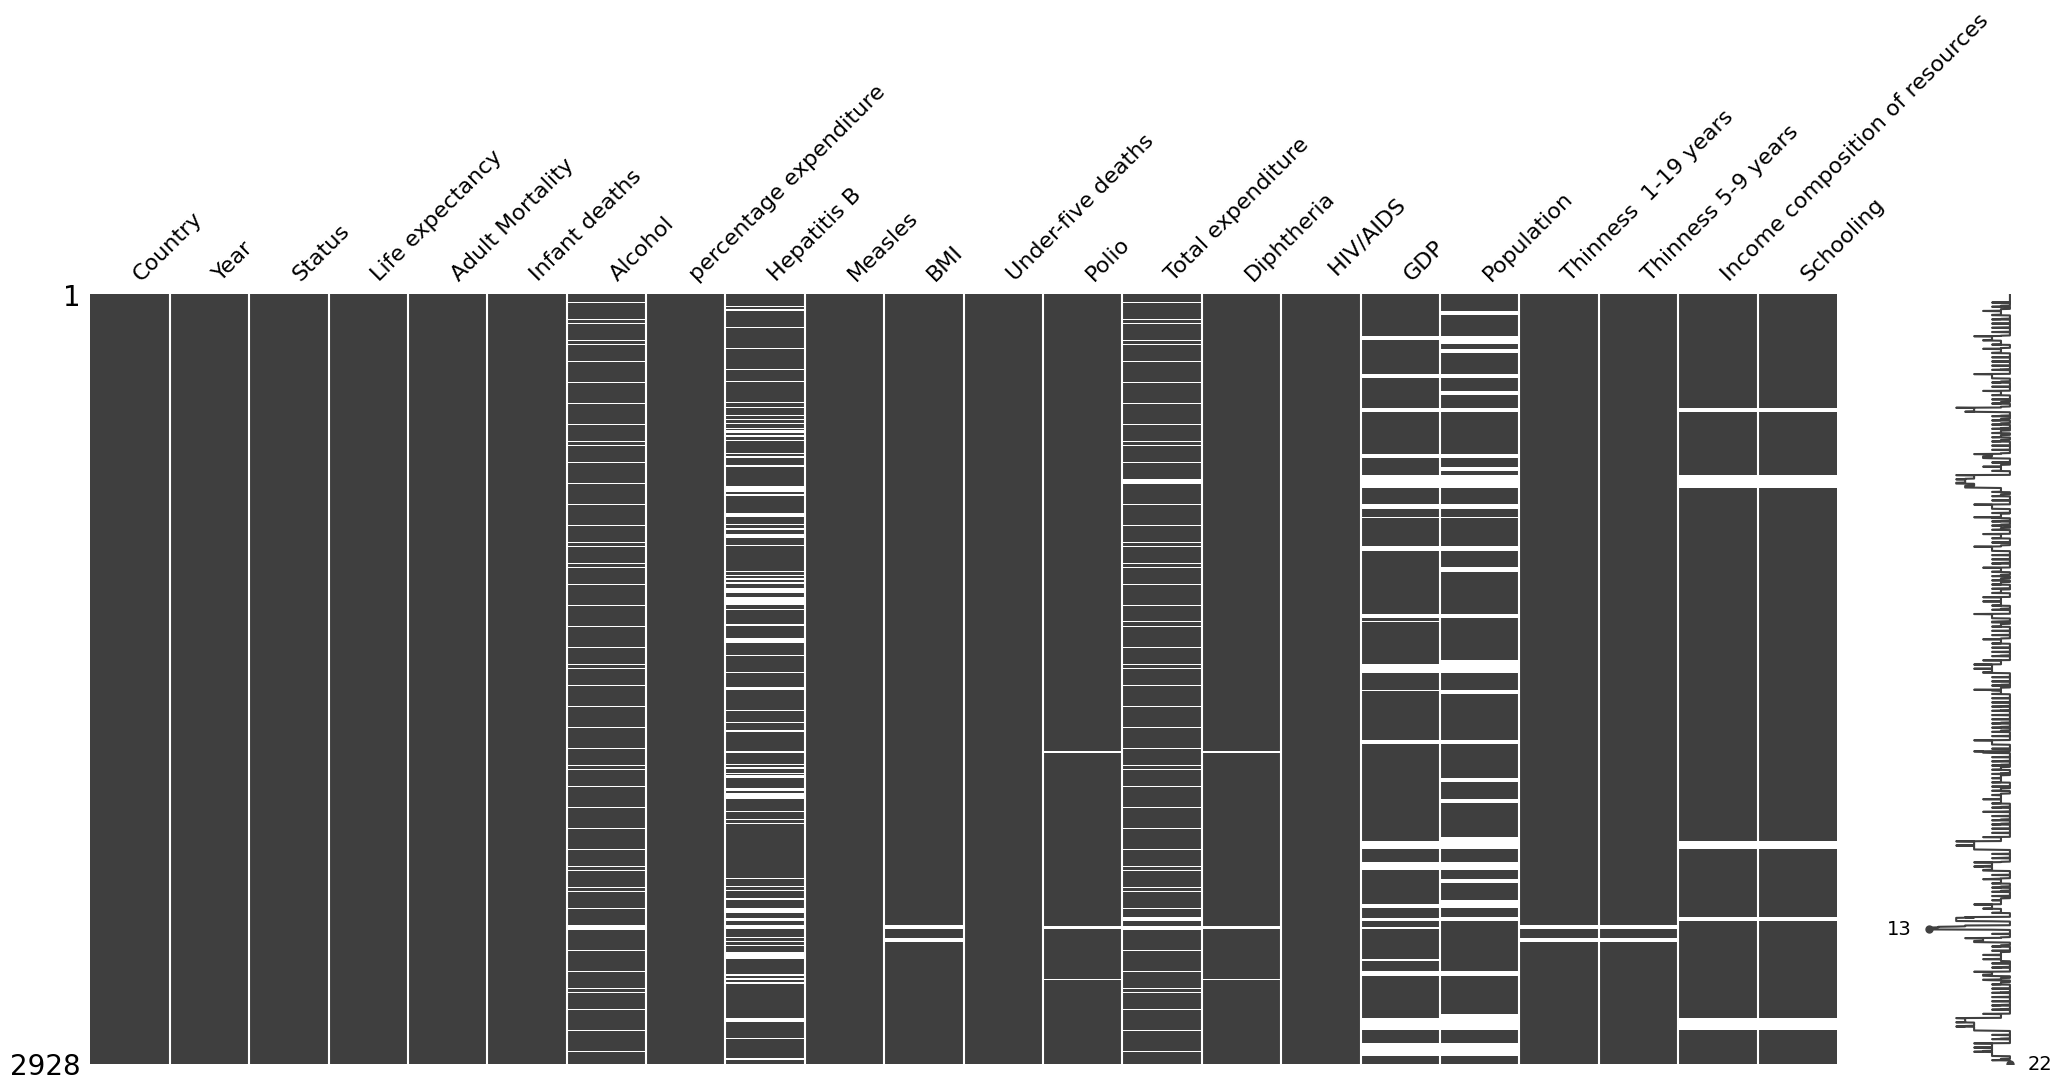

In [12]:
ds.dropna(axis=0, subset=['Life expectancy'], inplace=True)

# visualize missing data
msno.matrix(ds)

In [13]:
for i in ds.columns:
    print( ds[i].value_counts(),'\n\n')
    

Country
Afghanistan                                             16
New Zealand                                             16
Niger                                                   16
Nigeria                                                 16
Norway                                                  16
Oman                                                    16
Pakistan                                                16
Panama                                                  16
Papua New Guinea                                        16
Paraguay                                                16
Peru                                                    16
Philippines                                             16
Poland                                                  16
Portugal                                                16
Qatar                                                   16
Republic of Korea                                       16
Republic of Moldova                             

In [14]:
# Логіка для присвоєння значень відповідно до умов
def assign_Alcohol(row):
    if row['Status'] == 'Developing':
        return 2.5
    else:
        return 10

ds["Alcohol"].fillna(ds.apply(assign_Alcohol, axis=1), inplace=True)


In [15]:
 miss=missing(ds) # 30=1%

Hepatitis B 553
BMI 32
Polio 19
Total expenditure 226
Diphtheria 19
GDP 443
Population 644
Thinness  1-19 years 32
Thinness 5-9 years 32
Income composition of resources 160
Schooling 160


In [16]:
def fill_missing(df):
    # Ensure the DataFrame is sorted by Country and Year
    df = df.sort_values(by=['Country', 'Year'])
    
    # Compute the mode of the  column, dropping NaN values
    mode_population = df['Population'].median()
    mode_GDP = df['GDP'].median()
    mode_Schooling = df['Schooling'].median()
    mode_Hepatitis = df['Hepatitis B'].median()
    mode_Total = df['Total expenditure'].median()

    
    # Iterate over each country
    for country in df['Country'].unique():
        # Filter the dataframe for the current country
        country_df = df[df['Country'] == country]
        
        # Fill missing values using forward fill and backward fill
        country_df['Population'] = country_df['Population'].fillna(method='ffill').fillna(method='bfill')
        country_df['GDP'] = country_df['GDP'].fillna(method='ffill').fillna(method='bfill')
        country_df['Schooling'] = country_df['Schooling'].fillna(method='ffill').fillna(method='bfill')
        country_df['Hepatitis B'] = country_df['Hepatitis B'].fillna(method='ffill').fillna(method='bfill')
        country_df['Total expenditure'] = country_df['Total expenditure'].fillna(method='ffill').fillna(method='bfill')
        
        # Update the original DataFrame with the filled values
        df.update(country_df)
    
    # For any remaining NaNs in the population column, fill with the mode value
    if mode_population is not None:
        df['Population'] = df['Population'].fillna(mode_population)
        df['GDP'] = df['GDP'].fillna(mode_GDP)
        df['Schooling'] = df['Schooling'].fillna(mode_Schooling)
        df['Hepatitis B'] = df['Hepatitis B'].fillna(mode_Hepatitis)
        df['Total expenditure'] = df['Total expenditure'].fillna(mode_Total)
    
    return df

In [17]:
ds = fill_missing(ds)


In [18]:
miss=missing(ds) # 30=1%


BMI 32
Polio 19
Diphtheria 19
Thinness  1-19 years 32
Thinness 5-9 years 32
Income composition of resources 160


In [19]:
median_valueIncome = ds['Income composition of resources'].median()
ds['Income composition of resources'] = ds['Income composition of resources'].fillna(median_valueIncome)

median_valueBMI = ds['BMI'].median()
ds['BMI'] = ds['BMI'].fillna(median_valueBMI)

_valueDiphtheria = ds['Diphtheria'].median()
ds['Diphtheria'] = ds['Diphtheria'].fillna(_valueDiphtheria)

_valuePolio = ds['Polio'].median()
ds['Polio'] = ds['Polio'].fillna(_valuePolio)


In [20]:
def fill_missing_with_random(df, column_name, low=None, high=None):
    # Determine the bounds for the random values
    if low is None:
        low = df[column_name].min()
    if high is None:
        high = df[column_name].max()

    # Generate random values to fill NaNs
    random_values = np.random.uniform(low, high, size=df[column_name].isnull().sum())

    # Fill NaNs with the generated random values
    df.loc[df[column_name].isnull(), column_name] = random_values
    
    return df

In [21]:
ds = fill_missing_with_random(ds, 'Thinness  1-19 years' )
ds = fill_missing_with_random(ds, 'Thinness 5-9 years')


In [22]:
missing(ds) # 30=1%


[]

In [23]:
ds = ds[ds['Infant deaths'] <= 1000]#drop anomalies 
ds = ds[ds['Under-five deaths'] <= 1000]#drop anomalies 
ds = ds[ds['Measles'] <= 1000]#drop anomalies 


In [24]:
ds.head()

,Country,Year,Status,Life expectancy,Adult Mortality,Infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
12,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.089053,65.0,798,13.4,122,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
11,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.296066,67.0,466,13.8,120,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
31,Albania,2000,Developing,72.6,11.0,1,3.66,91.711541,96.0,662,45.0,1,97.0,6.26,97.0,0.1,1175.788981,38927.0,2.1,2.2,0.656,10.7


In [25]:
low = ds['GDP'].min()
high = ds['GDP'].max()

print(low)
print(high)

5.6687264
119172.7418


In [26]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2403 entries, 12 to 2922
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2403 non-null   object 
 1   Year                             2403 non-null   int64  
 2   Status                           2403 non-null   object 
 3   Life expectancy                  2403 non-null   float64
 4   Adult Mortality                  2403 non-null   float64
 5   Infant deaths                    2403 non-null   int64  
 6   Alcohol                          2403 non-null   float64
 7   percentage expenditure           2403 non-null   float64
 8   Hepatitis B                      2403 non-null   float64
 9   Measles                          2403 non-null   int64  
 10  BMI                              2403 non-null   float64
 11  Under-five deaths                2403 non-null   int64  
 12  Polio                   

In [27]:
label_encoder = LabelEncoder()
#encoding
ds['Status'] = label_encoder.fit_transform(ds['Status'])
ds['Country'] = label_encoder.fit_transform(ds['Country'])



In [28]:
ds.head()

,Country,Year,Status,Life expectancy,Adult Mortality,Infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
12,0,2003,1,56.7,295.0,87,0.01,11.089053,65.0,798,13.4,122,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
11,0,2004,1,57.0,293.0,87,0.02,15.296066,67.0,466,13.8,120,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8
2,0,2013,1,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
1,0,2014,1,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
31,1,2000,1,72.6,11.0,1,3.66,91.711541,96.0,662,45.0,1,97.0,6.26,97.0,0.1,1175.788981,38927.0,2.1,2.2,0.656,10.7


In [29]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2403 entries, 12 to 2922
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2403 non-null   int32  
 1   Year                             2403 non-null   int64  
 2   Status                           2403 non-null   int32  
 3   Life expectancy                  2403 non-null   float64
 4   Adult Mortality                  2403 non-null   float64
 5   Infant deaths                    2403 non-null   int64  
 6   Alcohol                          2403 non-null   float64
 7   percentage expenditure           2403 non-null   float64
 8   Hepatitis B                      2403 non-null   float64
 9   Measles                          2403 non-null   int64  
 10  BMI                              2403 non-null   float64
 11  Under-five deaths                2403 non-null   int64  
 12  Polio                   

In [30]:
ds.head()


,Country,Year,Status,Life expectancy,Adult Mortality,Infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
12,0,2003,1,56.7,295.0,87,0.01,11.089053,65.0,798,13.4,122,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
11,0,2004,1,57.0,293.0,87,0.02,15.296066,67.0,466,13.8,120,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8
2,0,2013,1,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
1,0,2014,1,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
31,1,2000,1,72.6,11.0,1,3.66,91.711541,96.0,662,45.0,1,97.0,6.26,97.0,0.1,1175.788981,38927.0,2.1,2.2,0.656,10.7


In [31]:
missing(ds)

[]

In [ ]:
#lab 3

In [ ]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
X =  ds.drop(['Life expectancy'],axis=1)

In [ ]:
y =  ds['Life expectancy']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

# Define your models
lm = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state=42)
xgbt = xgb.XGBRegressor(random_state=42)
et = ExtraTreesRegressor(random_state=42)

# List of algorithms
algo = [xgbt, lm, ridge, lasso, knn, rf, et]

# Results list
result = []

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for i in algo:
    start = time.process_time()
    
    # Calculate cross-validation scores
    train_scores = cross_val_score(i, X_train, y_train, cv=cv, scoring='r2')
    test_scores = cross_val_score(i, X_test, y_test, cv=cv, scoring='r2')
    
    # Calculate additional metrics if needed
    train_rmse = np.sqrt(-cross_val_score(i, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
    test_rmse = np.sqrt(-cross_val_score(i, X_test, y_test, cv=cv, scoring='neg_mean_squared_error'))
    train_mae = -cross_val_score(i, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    test_mae = -cross_val_score(i, X_test, y_test, cv=cv, scoring='neg_mean_absolute_error')

    # Append results
    result.append([
        str(i).split("(")[0] + str("_baseline"), 
        np.mean(train_scores), 
        np.mean(test_scores),
        np.mean(train_rmse),
        np.mean(test_rmse),
        np.mean(train_mae),
        np.mean(test_mae)
    ])
    
    print(str(i).split("(")[0], "✓    ", "{}".format(round(time.process_time() - start, 3)), "sec")

# Create DataFrame from results
result = pd.DataFrame(result, columns=["Algorithm", "Train_Score", "Test_Score", "Train_Rmse", "Test_Rmse", 
                                       "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
result


In [ ]:
from sklearn.model_selection import GridSearchCV
def def_train(column):
    """
    Train an ExtraTreesRegressor model, perform grid search for hyperparameter tuning, and display quality metrics.
    Parameters:
    column (str): The name of the target variable column.
    Returns:
    None
    """
    target = ds[column]
    predictor_var = ds.drop([column], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(predictor_var, target, test_size=0.25, random_state=42)
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = ExtraTreesRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    # Perform grid search
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    y_predict = best_rf.predict(X_test)
    
    # Perform cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(best_rf, predictor_var, target, cv=kfold, scoring='r2')
    
    # Display cross-validation results
    print("Best Parameters:", grid_search.best_params_)
    print("Best GridSearchCV Score:",grid_search.best_score_)
    print("Cross-Validation Scores (R²):", cv_results)
    print("Mean Cross-Validation Score (R²):", cv_results.mean())

In [ ]:
print(f"\nTraining model for '{'Life expectancy'}'")
def_train('Life expectancy')

In [ ]:
def show_feature_importance(X_train, y_train, feature_names):
    """
    Train a Regressor model and display feature importances.

    Parameters:
    X_train (pandas.DataFrame): The training features.
    y_train (pandas.Series): The target variable for training.
    feature_names (list): Names of the features.

    Returns:
    None
    """
    # Initialize and train Regressor model
    rf = ExtraTreesRegressor(random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances
    importances = rf.feature_importances_

    # Create a DataFrame to display feature importances
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display feature importances
    print(importance_df)
    rankings = rf.feature_importances_.tolist()
    importance = pd.DataFrame(sorted(zip(X_train.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)
    
    plt.figure(figsize=(8,4))
    sns.barplot(x="importance",
                y="variable",
                data=importance[:10])
    plt.title('Variable Importance')
    plt.tight_layout()

In [ ]:
df=ds.drop(['Life expectancy'],axis=1)
feature_names=df.columns
show_feature_importance(X_train, y_train, feature_names)



In [ ]:
mtr = ds.corr()
mask = np.zeros_like(mtr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(16,9))
plt.title("Correlation Matrix in Heatmap", size=20)
sns.heatmap(mtr, mask= mask, annot=True, annot_kws={"size": 10});

In [ ]:
# Create a heatmap of the correlations with the target column
corr = ds.corr()
target_corr = corr['Life expectancy'].drop('Life expectancy')

    # Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)
plt.figure(figsize=(5, 10))
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title(f'Correlation with {'Life expectancy'}')
plt.show()